### Get a resume in pdf format

In [76]:
from __future__ import unicode_literals
from gensim.summarization import keywords
import pandas as pd

import nltk
import string
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import unicodedata
import math
import bytes
import os


import gensim
from gensim.models import Word2Vec
import logging

os.chdir(r"C:\Users\khans\Insight\Resume-Job-Description-Matching-master\Resume-Job-Description-Matching-master")

In [62]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 06 22:00:52 2017

@author: binoy
"""

import sys
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams
#from cStringIO import StringIO
from io import StringIO
def pdfparser(data):

    fp = open(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    # removed from the line above: , codec=codec
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()

    return data
    
with open('resumeconverted.txt','w') as f:
    f.write(pdfparser('Sherry Khansari.pdf'))

### Import input data file for jobs

In [63]:
import pandas as pd
import math

In [64]:
df = pd.read_csv("data.csv")
df.rename(columns = {'Unnamed: 0':'Job No.'}, inplace = True) 
df.head()

,Job No.,company,position,url,location,headquaters,employees,founded,industry,Job Description
0,1,Visual BI Solutions Inc,Graduate Intern (Summer 2017) - SAP BI / Big D...,https://www.glassdoor.com/partner/jobListing.h...,"Plano, TX","Plano, TX",51 to 200 employees,2010,Information Technology,"Location: Plano, TX or Oklahoma City, OK Dura..."
1,2,Jobvertise,Digital Marketing Manager,https://www.glassdoor.com/partner/jobListing.h...,"Dallas, TX","Berlin, Germany",1 to 50 employees,2011,Unknown,The Digital Marketing Manager is the front li...
2,3,Santander Consumer USA,"Manager, Pricing Management Information Systems",https://www.glassdoor.com/partner/jobListing.h...,"Dallas, TX","Dallas, TX",5001 to 10000 employees,1995,Finance,Summary of Responsibilities:The Manager Prici...
3,4,Federal Reserve Bank of Dallas,Treasury Services Analyst Internship,https://www.glassdoor.com/partner/jobListing.h...,"Dallas, TX","Dallas, TX",1001 to 5000 employees,1914,Finance,ORGANIZATIONAL SUMMARY: As part of the nati...
4,5,Aviall,"Intern, Sales Analyst",https://www.glassdoor.com/partner/jobListing.h...,"Dallas, TX","Dallas, TX",1001 to 5000 employees,Boeing,Subsidiary or Business Segment,Aviall is the world's largest provider of n...


### Data exploration

### Converting job title, description, and company name to list


In [65]:
jd = df['Job Description'].tolist()
companies = df['company'].tolist()
positions = df['position'].tolist()



#### Building the models

##### CountVectorizer Class

In [66]:
dir(str)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


##### Not sure about str.rstrip

In [67]:
class MyCountVectorizer:
    def __init__(self, docs):
        self.corpus = self.normalize_corpus(docs)
        self.make_features()
        self.make_matrix()
        
    def normalize_corpus(self, docs):    
        #table = string.maketrans(string.punctuation, 
         #                        len(string.punctuation) * ' ')
        
        table = str.rstrip(string.punctuation, 
                                 len(string.punctuation) * ' ')
        
        norm_docs = []
        for doc_raw in docs:
            doc = filter(lambda x: x in string.printable, doc_raw)
            '''
            doc = ''
            for x in doc_raw:
                if x in string.printable:
                    doc += x
            '''
            doc = str(doc).translate(table).lower()
            norm_docs.append(doc)
        #self.corpus = norm_docs
        return norm_docs
        
    def make_features(self):
        ''' create vocabulary set from the corpus '''
        stopwords = nltk.corpus.stopwords.words('english')
        self.features = set()
        for doc in self.corpus:
            for word in doc.split():
                if word not in stopwords:
                    self.features.add(word)
        #self.features = set([word for doc in self.corpus for word in doc.split() if word not in stopwords])
        self.features = sorted(list(self.features))

    def make_matrix(self):
        self.matrix = []
        for doc in self.corpus:
            doc_vec = []
            for word in self.features:
                tf = self.term_freq(word, doc)
                doc_vec.append(tf)
            self.matrix.append(doc_vec)

    def term_freq(self, term, document):
        words = document.split()
        count = 0
        for word in words:
            if word == term:
                count += 1
        return count
    
    def print_matrix(self):
        for vec in self.matrix:
            print(vec)

    def get_matrix(self):
        return self.matrix
    
    def get_features(self):
        return self.features
    
    def get_density(self):
        ''' get the density (# of non-zero elements / # all elements )'''
        counter = 0
        total = 0
        for row in self.matrix:
            for item in row:
                if item != 0:
                    counter += 1
                total += 1
        return 1.0 * counter / total

##### TFIDF Vectorizer

In [68]:
class MyTfIdfVectorizer(MyCountVectorizer):
    ''' inherits from MyCountVectorizer'''

    def make_matrix(self):
        'overriding method'
        self.matrix = []
        for doc in self.corpus:
            doc_vec = []
            for word in self.features:
                tf = self.term_freq(word, doc)
                idf = self.inverse_document_freq(word)
                doc_vec.append(tf * idf)
            #self.matrix.append(doc_vec)
            total = sum(doc_vec)
            doc_vec_norm = [i/total for i in doc_vec]
            self.matrix.append(doc_vec_norm)

    def inverse_document_freq(self, term):
        doc_count = 0
        for document in self.corpus:
            term_count = self.term_freq(term, document)
            if term_count > 0:
                doc_count += 1
        return math.log( 1.0 * len(self.corpus) / doc_count)

##### Plotting

In [69]:
def plot_mds(mean_vec):   
   from sklearn.manifold import MDS
    
   data = mean_vec
   mds = MDS(n_components=2, random_state=1)
   pos = mds.fit_transform(data)
   xs,ys = pos[:,0], pos[:,1]
   for x, y in zip(xs, ys):
       plt.scatter(x, y)
    #    plt.text(x, y, name)
    #pos2 = mds.fit_transform(model.infer_vector(resume))
    #xs2,ys2 = pos2[:,0], pos2[:,1]
   plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
   plt.text(xs[-1], ys[-1],'resume')
   plt.suptitle('MDS')
   plt.grid()
   plt.savefig('distance_MDS_improved.png')
   plt.show()

def plot_pca(meav_vec):
    from sklearn.decomposition import PCA
    data = mean_vec
    pca = PCA(n_components=2) #, whiten=True
    X = pca.fit_transform(data)
    xs,ys =X[:,0], X[:,1]
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.grid()
    plt.suptitle('PCA')
    plt.savefig('distance_PCA_improved.png')
    plt.show()

##### Open the resume that has been converted to text and add it to the dataset

In [70]:
with open('resumeconverted.txt','r') as f:
    resume = f.read()
jd.append(resume)
myvec = MyTfIdfVectorizer(jd)

In [71]:
myvec

In [73]:


# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

#### Build the model

In [81]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

2020-01-22 16:05:20,320 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin


FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin'

In [84]:
import wget

wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

from gensim import models

w = models.KeyedVectors.load_word2vec_format(
    '../GoogleNews-vectors-negative300.bin', binary=True)

SyntaxError: invalid syntax (<ipython-input-84-2b6c03147a35>, line 3)

In [85]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

2020-01-22 16:08:08,305 : INFO : Creating C:\Users\khans/gensim-data


[==================================================] 100.0% 1662.8/1662.8MB downloaded


2020-01-22 17:00:24,012 : INFO : word2vec-google-news-300 downloaded
2020-01-22 17:00:24,039 : INFO : loading projection weights from C:\Users\khans/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2020-01-22 17:03:05,836 : INFO : loaded (3000000, 300) matrix from C:\Users\khans/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [97]:
model = wv

In [94]:
word_vectors = model.wv

C:\Users\khans\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [95]:
word_vectors

In [ ]:
#import gensim.downloader as api

#model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
#word_vectors = model.wv #load the vectors from the model

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model.save_word2vec_format('googlenews2.txt')

In [100]:
stopwords = nltk.corpus.stopwords.words('english')

imp = ['java']
vec = []

for j in jd:
    x = j.translate(str.maketrans('', '', string.punctuation))
    y = x.translate(str.maketrans('', '', string.digits))
    jd_vector = []
    i = 0
    
    for word in y.split():
        if word.lower() not in stopwords and len(word)>1 and word not in imp:
            try:
                x = model[word]
                idx = myvec.get_features().index(word)
                z = myvec.get_matrix()[i][idx]
                lst = [a * z for a in x]
                jd_vector.append(lst)
            except:
                continue
    
        else:
            try:
                x = model[word]
                lst = [a * 2 for a in x]
                jd_vector.append(lst)
            except:
                continue
    i+=1
    vec.append(jd_vector)


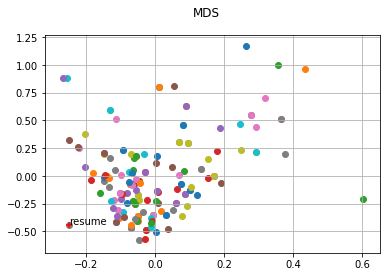

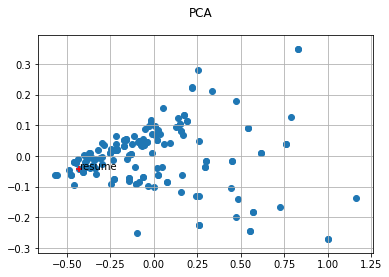

In [101]:
mean_vec = []
for j in vec:
    mean = []
    for i in range(300):
        accum =0
        for word in j:
            accum += word[i]
        mean.append(1.0*accum/len(word))
    mean_vec.append(mean)
data = mean_vec

plot_mds(mean_vec)
plot_pca(mean_vec)
        

In [107]:
len(data)

158

In [121]:
import numpy as np
v1,v2 = [3, 45, 7, 2], [2, 54, 13, 15]
v1 = np.array(v1)
v2 = np.array(v2)
v1 = v1.reshape(1,-1)
v2 = v2.reshape(1,-1)
print(cosine_similarity(v1,v2))

[[0.97228425]]


In [130]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
cos_dist =[]

data[-1] = np.array(data[-1])
data[-1] = data[-1].reshape(1,-1)

for vec in data[:-1]:
    vec = np.array(vec)
    vec = vec.reshape(1,-1)
    cos_dist.append(float(cosine_distances(vec,data[-1])))
    

ps = PorterStemmer()
key_list =[]

for j in jd[:-1]:
    key = ''
    w = set()
    for word in keywords(j).split('\n'):
        w.add(ps.stem(word))
    for x in w:
        key += '{} '.format(x)
    key_list.append(key)


In [133]:
summary = pd.DataFrame({
        'Company': companies,
        'Postition': positions,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
        'Job Description': jd[:-1]
    })
z =summary.sort_values('Cosine Distances', ascending=False)
z.to_csv('Summaryimproved.csv',encoding="utf-8")